In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore
from mcmodels.core import Mask

from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:12], experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
connectivity_data.get_data_matrices(default_structure_ids)

In [5]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)

#contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
#ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order_leaves)[np.isin(ontological_order_leaves, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
connectivity_data.get_crelines(data_info)


with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)

summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)

connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.str2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [7]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #meani = meani = means_cast[sids[i]][cres[i]]
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)


def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary,gamma_dict = None):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    #reorder = np.concatenate([ipsi_indices, contra_indices])  
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface_cv, cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_norm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)


def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

    
def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)

def get_loss_surface_cv_control(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances_control(projections,centroids,np.zeros(cre_distances_cv.shape), fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances_control(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)[0]#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    return(surface)

def get_embedding_cv_control(surface, dists, cre_distances_cv):
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        #p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, 0.]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)

In [8]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000


In [9]:

for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.leafs[sid],
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


In [12]:

def get_summaryleaf_combos(connectivity_data):

    #connectivity_data = self
    #leafs = self.leafs
    creline = connectivity_data.creline
    crestrs = {}
    crestrs_merged = {}

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        strs = connectivity_data.structure_datas[sid].summary_structures
        crestrs[sid] = np.asarray(np.vstack([strs, creline[sid]]), dtype=str).transpose()
        crestrs_merged[sid] = [crestrs[sid][:, 0][i] + crestrs[sid][:, 1][i] for i in range(crestrs[sid].shape[0])]
        crestrs_merged[sid] = np.asarray(crestrs_merged[sid])
    connectivity_data.crestrs_combos = crestrs_merged
    return(connectivity_data)
connectivity_data = get_summaryleaf_combos(connectivity_data)

connectivity_data.crestr2_index_matrices = get_indices_2ormore(connectivity_data.crestrs_combos)

In [13]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
m 4 2 0.0020073974 0.0012813909801480132
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
m 5 2 0.0020073974 0.0011904112797874852
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0020073974 nan
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0.0020073974 nan
(31, 7, 36, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
m 0 2 0.0030163364 0.0033898193160578
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0030163364 nan
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
m 2 3 0.0030163364 0.0018428283753179281
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0030163364 nan
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
m 4 2 0.0030163364 0.001888882845230131
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
e [55 60] m [55 60]
m 5 2 0.0030163364 0.0022825384817892

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 12 0 0.0030163364 nan
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
m 13 2 0.0030163364 0.004616407110500293
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.0030163364 nan
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
m 15 6 0.0030163364 0.0019963264964309555
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.0030163364 nan
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [

m 67 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 68 0 0.0030163364 nan
(69, 7, 122, 1077)
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
m 0 2 0.005063931 0.009418444276989511
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
m 22 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.005063931 nan
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
m 26 3 0.005063931 0.003140315990734985
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
m 27 3 0.005063931 0.003910551998857237
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.005063931 nan
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 2 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549515
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.0071121926837175616
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 

m 73 0 0.004280918 nan
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
m 74 3 0.004280918 0.004547752184986587
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
m 75 2 0.004280918 0.005175282029306529
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
m 76 2 0.004280918 0.006519364934986412
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
m 77 2 0.004280918 0.005182189981619314
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

m 113 0 0.004280918 nan
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
m 114 3 0.004280918 0.003842282540224739
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 115 0 0.004280918 nan
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
m 116 2 0.004280918 0.0037441076713388695
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
m 117 2 0.004280918 0.003714040022034194
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 118 0 0.004280918 nan
e [  86 1117] m [  86 1117]
e [  86 1117] m [  86 1117]
e [  86 1117] m [  8

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 141 2 0.004280918 0.004166332709041238
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
m 142 3 0.004280918 0.002999133429633845
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
m 143 2 0.004280918 0.00469403065852346
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 144 0 0.004280918 nan
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  8

m 199 2 0.004280918 0.003404606822618058
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 200 0 0.004280918 nan
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
m 201 4 0.004280918 0.004874969654740973
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 202 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 203 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 204 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 205 0 0.004280918 nan
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]


m 217 0 0.004280918 nan
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
m 218 3 0.004280918 0.0035768118065644568
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097]
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097]
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   

m 239 11 0.004280918 0.003536919960282092
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
m 240 2 0.004280918 0.0026430433455224413
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
m 241 2 0.004280918 0.0030514041957758844
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
m 242 3 0.004280918 0.004056889102525507
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 243 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 244 0 0.004280918 nan
e [ 103  818  986 1079] m [ 103  818  986 1079]
e [ 103  818  986 1079] m [ 103  818 

m 277 2 0.004280918 0.0036972641388213524
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 278 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 279 0 0.004280918 nan
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
m 280 3 0.004280918 0.004337674070608879
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 281 0 0.004280918 nan
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
m 282 3 0.004280918 0.004445556863936485
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 9

m 315 3 0.004280918 0.00594290119767108
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
m 316 2 0.004280918 0.004558094851000979
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
m 317 3 0.004280918 0.005094018624841909
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 318 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 319 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 320 0 0.004280918 nan
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 8

m 366 2 0.004280918 0.004090929550722706
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
m 367 3 0.004280918 0.004530541753911793
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 368 0 0.004280918 nan
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
m 369 3 0.004280918 0.0059473607184163235
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 370 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 371 0 0.004280918 nan
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257

m 422 3 0.004280918 0.0049815120718696
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 423 0 0.004280918 nan
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
m 424 3 0.004280918 0.0051647565131925895
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 425 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 426 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 427 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 428 0 0.004280918 nan
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
m

e [] m []
e [] m []
e [] m []
m 472 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 473 0 0.004280918 nan
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
m 474 4 0.004280918 0.003432952308253966
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
m 475 2 0.004280918 0.0036174445097817247
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 476 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 477 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 478 0 0.004280918 nan
e [  61   7

m 503 12 0.004280918 0.0033593030549373564
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 504 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 505 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 506 0 0.004280918 nan
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
m 507 8 0.004280918 0.003796039450653551
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 508 0 0.004280918 nan
e [ 184  443  571  594  840  880  90

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
m 20 3 0.0044946857 0.0026647517451255285
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0044946857 nan
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
m 25 3 0.0044946857 0.0027121615866734865
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 11 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 12 0 0.0040149265 nan
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
m 13 2 0.0040149265 0.0060716178118137105
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
m 14 2 0.0040149265 0.005178355327

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
m 21 2 0.0024444947 0.0020338529020796563
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0024444947 nan
(24, 7, 35, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0049728127 nan
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
m 3 2 0.0049728127 0.009697715676376803
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.00

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0049728127 nan
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
m 28 2 0.0049728127 0.003059716363098103
(29, 7, 33, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0047248537 nan
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
m 20 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0047248537 nan
e [20 25] m [20 25]
e [20 25] m [20 25]
e [20 25] m [20 25]
e [20 25] m [20 25]
e [20 25] m [20 25]
e [20 25] m [20 25]
e [20 25] m [20 25]
m 22 2 0.0047248537 0.006704238494391927
e [13 28] m [13 28]
e [13 28] m [13 28]
e [13 28] m [13 28]
e [13 28] m [13 28]
e [13 28] m [13 28]
e [13 28] m [13 28]
e [13 28] m [13 28]
m 23 2 0.0047248537 0.0065394356049835334
(24, 7, 30, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0021694691 nan
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
m 8 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 11 0 0.0021694691 nan
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
e [ 3 20 59] m [ 3 20 59]
m 12 3 0.0021694691 0.0029479455914580674
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 13 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 15 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 1  7 16 22 37 40 56 58] m [ 1  7 16 22 37 40 56 58]
e [ 1  7 16 22 37 40 56 58] m [ 1  7 16 22 37 40 56 58]
e [ 1  7 16 22 37 40 56 58] m [ 1  7 16 22 37 40 56 58]
e [ 1  7 16 22 37 40 56 58] m [ 1  7 16 22 37 40 56 58]
m 31 8 0.0021694691 0.0012279409932629355
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 32 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 33 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 34 0 0.0021694691 nan
e [21 67] m [21 67]
e [21 67] m [21 67]
e [21 67] m [21 67]
e [21 67] m [21 67]
e [21 67] m [21 67]
e [21 67] m [21 67]
e [21 67] m [21 67]
m 35 2 0.0021694691 0.007284400322657511
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
e [13 18 49 51 64] m [13 18 49 51 64]
m 36 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.003704043 nan
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
m 23 2 0.003704043 0.004202163954784398
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 

In [14]:
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0
1
2
3
4
5
6
7
8
9
10
11


In [15]:
meanloss_nw_leaf_leaf2_2stage

array([0.04942467, 0.60140432, 0.10076752, 0.26638121, 0.16699509,
       0.16000264, 0.22743446, 0.06539122, 0.2505118 , 0.20128429,
       0.05947587, 0.53641705])

In [16]:
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_control = get_loss_surface_cv_control(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(connectivity_data.creline[sid].shape[0]),
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 1000)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91

In [17]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv_control(surface = connectivity_data.structure_datas[sid].loss_surface_cv_control,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_control.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [18]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
m 4 2 0.0020073974 0.0012813909801480132
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
m 5 2 0.0020073974 0.0011904112797874852
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0020073974 nan
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0046113897 nan
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
m 4 2 0.0046113897 0.007226992534697425
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0046113897 nan
(6, 7, 7, 1077)
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
m 0 2 0.0030163364 0.0033898193160578
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0030163364 nan
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 8

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 16 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.0030163364 nan
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
m 18 2 0.0030163364 0.0019078487793733672
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
m 19 4 0.0030163364 0.0020303764107232718
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0030163364 nan
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 64 69]
e [15 40 64 69] m [15 40 6

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.005063931 nan
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
e [25 66 74 81] m [25 66 74 81]
m 10 4 0.005063931 0.0061508138215363595
e [] m []
e [] m []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 1 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549515
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.0071121926837175616
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0

m 73 0 0.004280918 nan
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
m 74 3 0.004280918 0.004754679684762145
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
m 75 2 0.004280918 0.005175282029306529
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
m 76 2 0.004280918 0.006519364934986412
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
m 77 2 0.004280918 0.005182189981619314
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

m 113 0 0.004280918 nan
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
m 114 3 0.004280918 0.004085656721034232
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 115 0 0.004280918 nan
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
m 116 2 0.004280918 0.0037441076713388695
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
m 117 2 0.004280918 0.003714040022034194
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 118 0 0.004280918 nan
e [  86 1117] m [  86 1117]
e [  86 1117] m [  86 1117]
e [  86 1117] m [  8

m 163 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 164 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 165 0 0.004280918 nan
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
e [ 14 428] m [ 14 428]
m 166 2 0.004280918 0.002699605798326877
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 167 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 168 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 169 0 0.004280918 nan
e [286 749] m [286 749]
e [286 749] m [286 749]
e [286 749] m [286 749]
e [286 749] m [286 749]
e [286 749] m [286 749]
e [286 749] m [286 749]
e [286 749] m [286 749]
m 170 2 0.004280918 0.005236474183522401
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 171 0 0.00428091

e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
e [  41   74   93  101  121  148  

m 228 7 0.004280918 0.0031745117001698805
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044]
e [ 111  214  303  316  357  411  473  487  521  648  698  898  910  933
  934 1044] m [ 111  214  303  316 

m 246 20 0.004280918 0.003739614332747414
e [322 999] m [322 999]
e [322 999] m [322 999]
e [322 999] m [322 999]
e [322 999] m [322 999]
e [322 999] m [322 999]
e [322 999] m [322 999]
e [322 999] m [322 999]
m 247 2 0.004280918 0.0042379004881830575
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 248 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 249 0 0.004280918 nan
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
m 250 3 0.004280918 0.006958688059503469
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27 

m 292 0 0.004280918 nan
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
e [ 864 1113] m [ 864 1113]
m 293 2 0.004280918 0.003447084300515573
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
e [  7  11 839] m [  7  11 839]
m 294 3 0.004280918 0.00547434574266571
e [251 482] m [251 482]
e [251 482] m [251 482]
e [251 482] m [251 482]
e [251 482] m [251 482]
e [251 482] m [251 482]
e [251 482] m [251 482]
e [251 482] m [251 482]
m 295 2 0.004280918 0.004370590861039175
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
e [533 752 903] m [533 752 903]
m 296 3 0.004280918 0.004817381341991097
e

m 332 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 333 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 334 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 335 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 336 0 0.004280918 nan
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
m 337 2 0.004280918 0.0034244545696976423
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
m 338 2 0.004280918 0.0048197525492079596
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
m 339 2 0.00

m 384 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 385 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 386 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 387 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 388 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 389 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 390 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 391 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 392 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 393 0 0.004280918 nan
e [ 809 1105] m [ 809 1105]
e [ 809 1105] m [ 809 1105]
e [ 809 1105] m [ 809 1105]
e [ 809 1105] m [ 809 1105]
e [ 809 1105] m [ 

m 436 0 0.004280918 nan
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
m 437 3 0.004280918 0.005078349521273346
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
m 438 2 0.004280918 0.007580716722615204
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
m 439 5 0.004280918 0.0035657173951370636
e [137 525 763 921] m [137 525 763 921]
e [137 525 763 921] m [137 525 763 921]
e [137 525 763 921] m [137 525 763 921]
e [1

m 480 5 0.004280918 0.003913921518518965
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 481 0 0.004280918 nan
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
e [ 389 1091] m [ 389 1091]
m 482 2 0.004280918 0.0033880111987100925
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 483 0 0.004280918 nan
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
e [ 881 1007] m [ 881 1007]
m 484 2 0.004280918 0.0028050289216742653
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
e [133 424 445] m [133 424 445]
m 485 3 0.004280918 0.0036280929453845483
e [380 730 794] m [380 730 79

m 510 0 0.004280918 nan
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
m 511 2 0.004280918 0.003251647345794022
(512, 7, 1128, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0044946857 nan
e [ 3  9 19 20] m [ 3  9 19 20]
e [ 3  9 19 20] m [ 3  9 19 20]
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 25 3 0.0044946857 0.003080186112604991
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0.0044946857 nan
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
m 31 2 0.0044946857 0.002733405434618765
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 32 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 33 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 34 0 0.0044946857 nan
e [] m []
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 32 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 33 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 34 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 35 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 36 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 37 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 38 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 39 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 40 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 41 0 0.0040149265 nan
(42, 7, 46, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0024444947 nan
e [] m []
e [] m []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 18 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0024444947 nan
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
e [ 8 32] m [ 8 32]
m 21 2 0.0024444947 0.0020338529020796563
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0024444947 nan
(24, 7, 35, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0049728127 nan
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0021694691 nan
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
m 4 2 0.0021694691 0.002452765996635506
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0021694691 nan
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
m 26 3 0.0021694691 0.001321850392099247
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
m 27 10 0.0021694691 0.0017691682526760097
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
m 23 2 0.003704043 0.004202163954784398
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
m 26 2 0.003704043 0.004426847388665806
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.003704043 nan
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
m 30 2 0.003704043 0.0025469176389139882
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e []

In [19]:
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0
1
2
3
4
5
6
7
8
9
10
11


In [20]:
meanloss_nw_leaf_leaf2_2stage

array([0.04942467, 0.60140432, 0.10441536, 0.2715907 , 0.1887134 ,
       0.17598924, 0.22215936, 0.06497074, 0.2505118 , 0.20127212,
       0.05975458, 0.5365584 ])

<IPython.core.display.Javascript object>


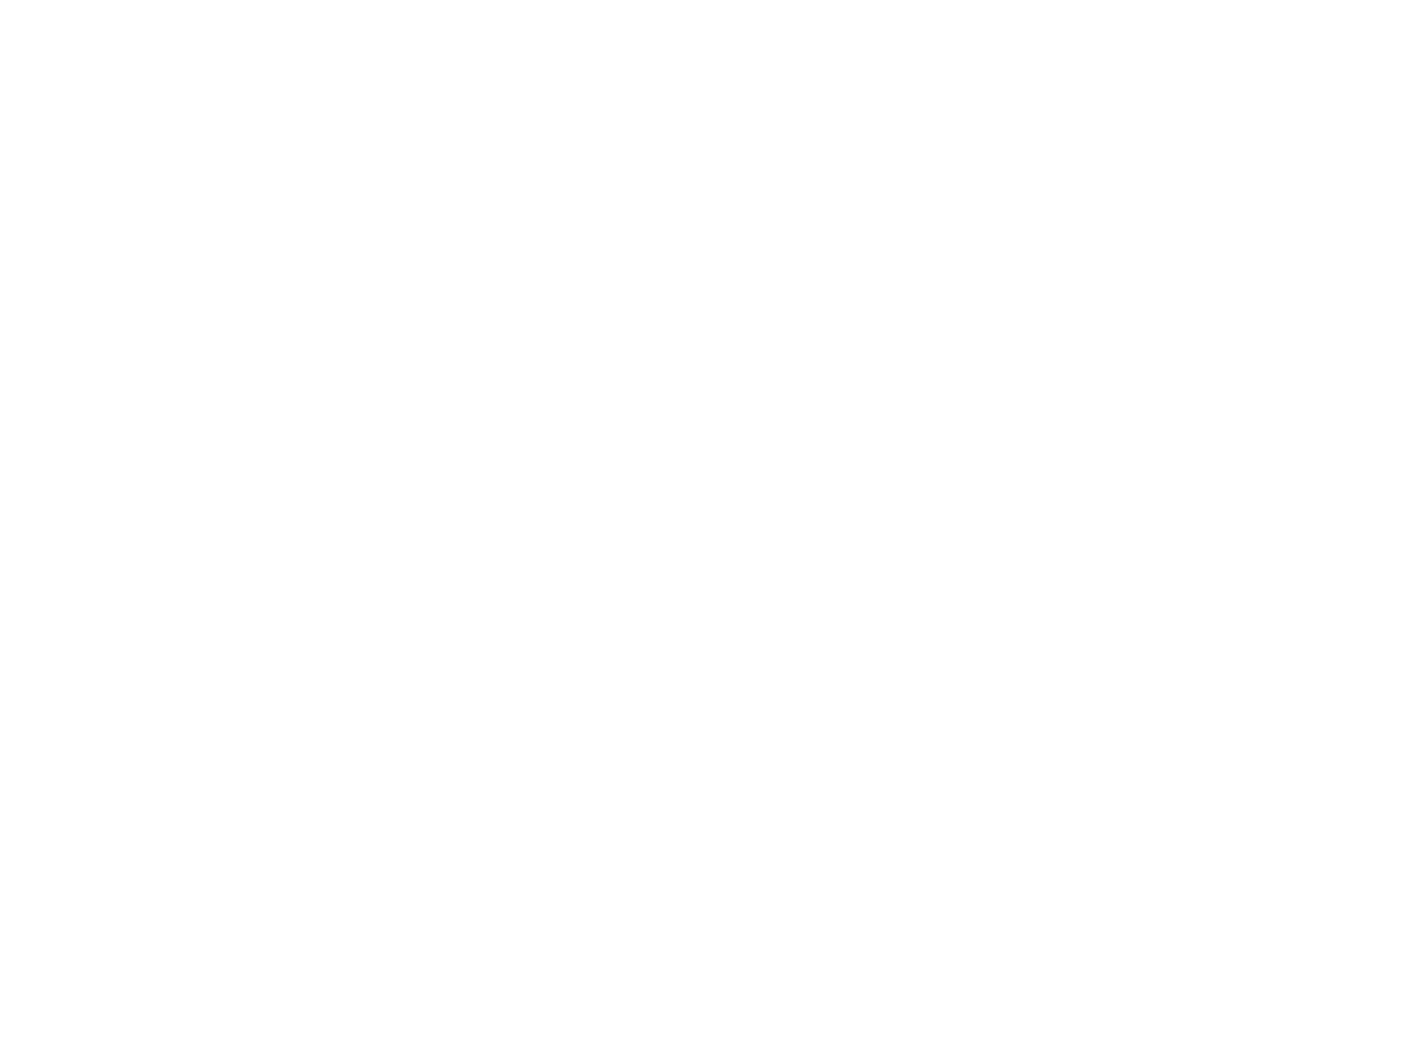

In [21]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_control)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

<IPython.core.display.Javascript object>


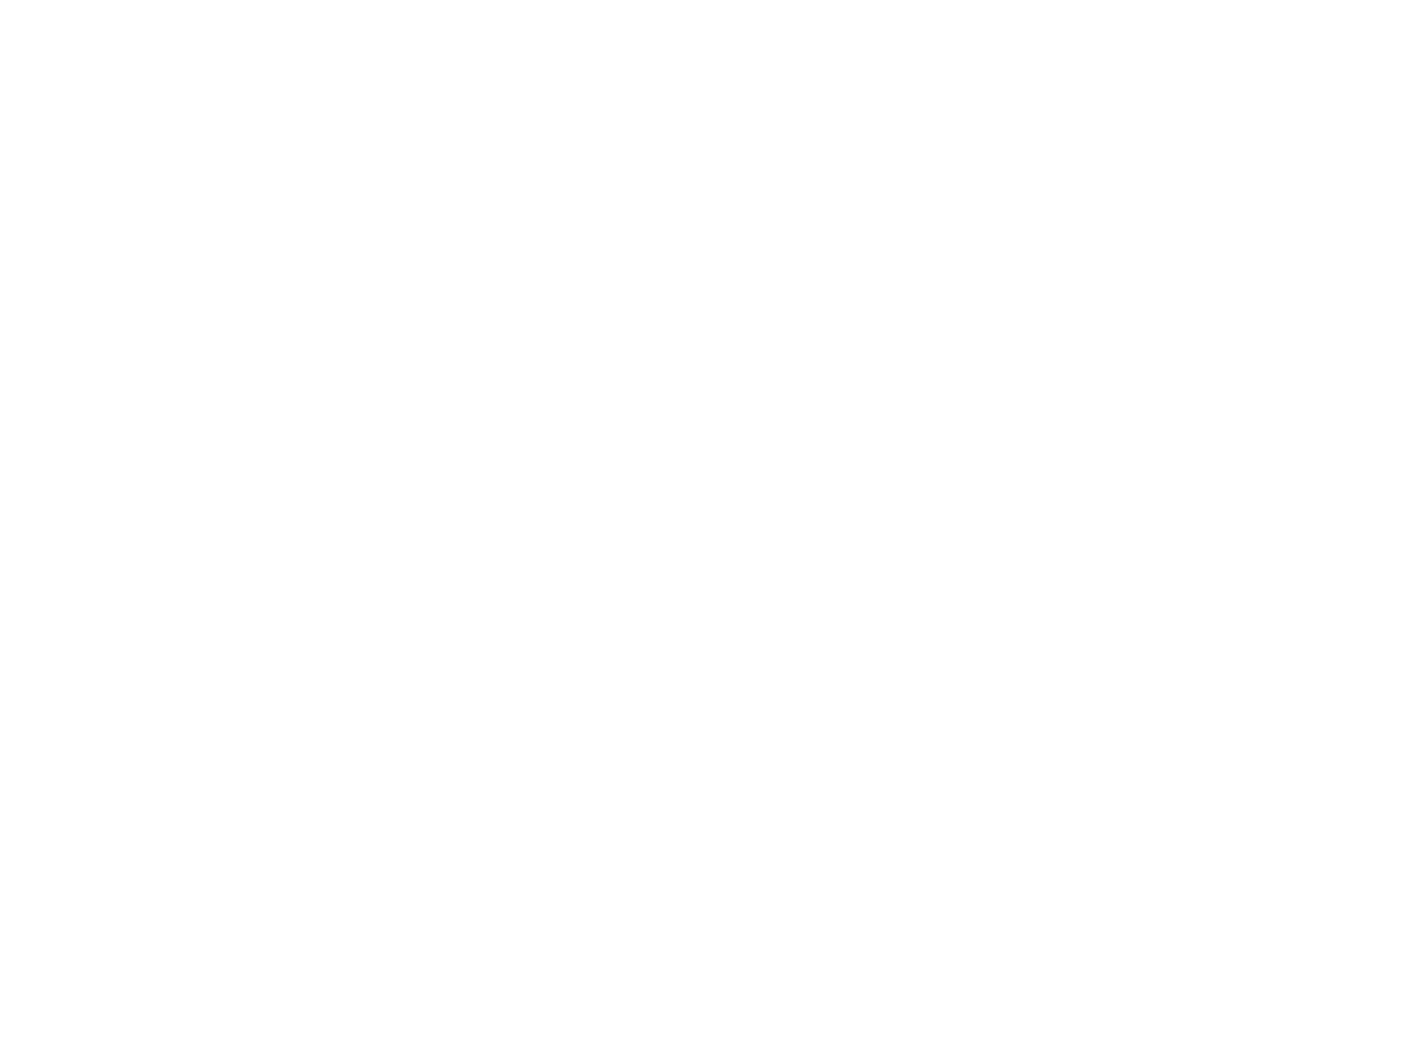

In [22]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv_control)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [23]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_control = get_loss_surface_cv_control(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(connectivity_data.creline[sid].shape[0]),
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 100000)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

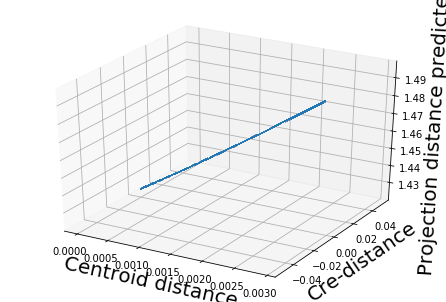

In [28]:
#%matplotlib inline
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_control)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [24]:
for m in range(4,5):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv_control(surface = connectivity_data.structure_datas[sid].loss_surface_cv_control,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_control.cre_distances_cv)

0
1
2
3


In [27]:
2+2

4

In [29]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_control = get_loss_surface_cv_control(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(connectivity_data.creline[sid].shape[0]),
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 1000000)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

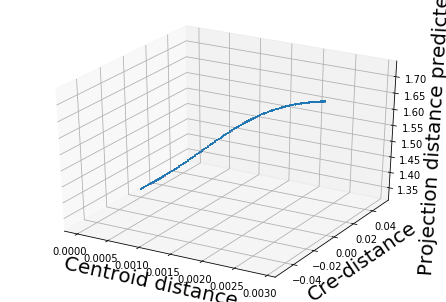

In [30]:
#%matplotlib inline
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_control)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [31]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_control = get_loss_surface_cv_control(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(connectivity_data.creline[sid].shape[0]),
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 10000000)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

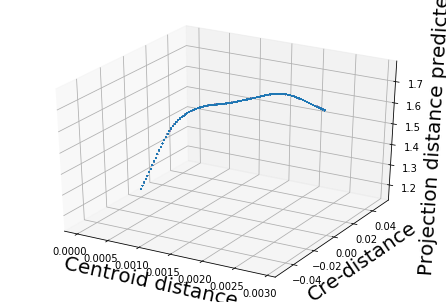

In [32]:
#%matplotlib inline
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_control)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [33]:
for m in range(4,5):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv_control(surface = connectivity_data.structure_datas[sid].loss_surface_cv_control,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_control.cre_distances_cv)

4


In [38]:
gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
m 4 2 0.0020073974 0.0012813909801480132
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
m 5 2 0.0020073974 0.0011904112797874852
e [] m []
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 22 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
m 0 2 0.0030163364 0.0033898193160578002
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0030163364 nan
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
m 2 3 0.0030163364 0.0023302515191505457
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0030163364 nan
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 80 115] m [ 80 115]
e [ 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 11 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 12 0 0.0030163364 nan
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
m 13 2 0.0030163364 0.004616407110500293
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.0030163364 nan
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]

m 57 2 0.0030163364 0.005345160011147555
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 58 0 0.0030163364 nan
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
e [ 72 117 121] m [ 72 117 121]
m 59 3 0.0030163364 0.005020810130134667
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
e [31 36 57 78] m [31 36 57 78]
m 60 4 0.0030163364 0.0036145799699020126
e [27 73 89] m [27 73 89]
e [27 73 89] m [27 73 89]
e [27 73 89] m [27 73 89]
e [27 73 89] m [27 73 89]
e [27 73

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
e [26 52] m [26 52]
m 15 2 0.005063931 0.004438076162585116
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.005063931 nan
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
e [ 3 16] m [ 3 16]
m 19 2 0.005063931 0.006336033260885177
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m [

m 0 4 0.004280918 0.005534443439859171
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 2 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549516
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.00711219268371756
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] 

m 55 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 56 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 57 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 58 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 59 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 60 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 61 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 62 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 63 0 0.0042809

m 91 3 0.004280918 0.0040647264023746885
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
e [122 135 502 678 862] m [122 135 502 678 862]
m 92 5 0.004280918 0.004043828210543337
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
e [ 44 308 991] m [ 44 308 991]
m 93 3 0.004280918 0.003798729720622625
e [275 330 523 540 873 893] m [275 330 523 540 873 893]
e [275 330 523 540 873 

m 121 0 0.004280918 nan
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
e [587 598] m [587 598]
m 122 2 0.004280918 0.0025841666170091627
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
e [ 158  923 1015] m [ 158  923 1015]
m 123 3 0.004280918 0.004629788526451509
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m [ 66 220 667]
e [ 66 220 667] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 141 2 0.004280918 0.004166332709041238
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
m 142 3 0.004280918 0.0030698044804978995
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
m 143 2 0.004280918 0.0046940306585234615
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 144 0 0.004280918 nan
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1

m 187 2 0.004280918 0.004037240030327777
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
m 188 2 0.004280918 0.0030770000708707163
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 189 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 190 0 0.004280918 nan
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
m 191 2 0.004280918 0.0038901276417032736
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027

m 210 31 0.004280918 0.005022559442124058
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 211 0 0.004280918 nan
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
e [125 164 578 830 849] m [125 164 578 830 849]
m 212 5 0.004280918 0.0027697963544056747
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 213 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 214 0 0.004280918 nan
e [ 88 117 633 990] m [ 88 117 633 990]
e [ 88 117 633 990] m [ 

m 226 3 0.004280918 0.0027519952801349783
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 227 0 0.004280918 nan
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
e [   1  169  439  591  754  787 1093] m [   1  169  439  591  754  787 1093]
m 228 7 0.004280918 0.0031612050341135087
e [ 111  214

m 239 11 0.004280918 0.0036197768501277394
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
m 240 2 0.004280918 0.0026430433455224417
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
m 241 2 0.004280918 0.0030514041957758844
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
m 242 3 0.004280918 0.003930988932659764
e [] m []
e [] m []
e [] m []
e 

m 264 3 0.004280918 0.00501164990572173
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 265 0 0.004280918 nan
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
m 266 2 0.004280918 0.004795193932176713
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 267 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 268 0 0.004280918 nan
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
m 269 2 0.004280918 0.0035125563253671373
e [] m []
e [] m []
e [] 

m 298 4 0.004280918 0.00614603944171394
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
e [ 510  537  544  764  882  930 1095] m [ 510  537  544  764  882  930 1095]
m 299 7 0.004280918 0.005861513493982853
e [171 339] m [171 339]
e [171 339] m [171 339]
e [171 339] m [171 339]
e [171 339] m [171 339]
e [171 339] m [171 339]
e [171 339] m [171 

m 327 2 0.004280918 0.004073698661355748
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
e [265 958] m [265 958]
m 328 2 0.004280918 0.005091799687637345
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 329 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 330 0 0.004280918 nan
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
m 331 2 0.004280918 0.0034409268214526134
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 332 0 

m 365 3 0.004280918 0.006709864427776281
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
m 366 2 0.004280918 0.004090929550722705
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
e [454 514 625] m [454 514 625]
m 367 3 0.004280918 0.004549859151291325
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 368 0 0.004280918 nan
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e

m 412 2 0.004280918 0.006032078589486384
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 413 0 0.004280918 nan
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
e [ 177  310  716 1020] m [ 177  310  716 1020]
m 414 4 0.004280918 0.0034390891606547384
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
e [426 828] m [426 828]
m 415 2 0.004280918 0.005292827617283024
e [] m []
e [] m []
e [] m []
e 

m 441 0 0.004280918 nan
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
m 442 2 0.004280918 0.004814324972219238
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 443 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 444 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 445 0 0.004280918 nan
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] m [ 100  376 1112]
e [ 100  376 1112] 

m 475 2 0.004280918 0.0036174445097817243
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 476 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 477 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 478 0 0.004280918 nan
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055]
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055]
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055]
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055]
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055]
e [  61   78  161  224  350  392  646 1049 1055] m [  61   78  161  224  350  392  646 1049 1055

m 499 9 0.004280918 0.0037929508038572887
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
e [ 25 927] m [ 25 927]
m 500 2 0.004280918 0.0025744897116406107
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
e [141 494 704] m [141 494 704]
m 501 3 0.004280918 0.003001650732593851
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 705]
e [332 403 705] m [332 403 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0044946857 nan
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
e [36 47 53] m [36 47 53]
m 20 3 0.0044946857 0.0026046802133206405
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0024444947 nan
(24, 10, 35, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0049728127 nan
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
m 3 2 0.0049728127 0.009697715676376801
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
m 18 2 0.0049728127 0.0042241519051998975
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 11 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 12 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 13 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 15 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.0047248537 nan
e [] m []
e [] m []
e [] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0021694691 nan
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
e [26 74] m [26 74]
m 23 2 0.0021694691 0.0028821214946466033
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
e [18 32] m [18 32]
m 16 2 0.003704043 0.0031429033945217072
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.003704043 nan
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e

In [39]:
a= [list(range(10))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0
1
2
3
4
5
6
7
8
9
10
11


In [40]:
meanloss_nw_leaf_leaf2_2stage

array([0.04942467, 0.60140432, 0.10075866, 0.26665816, 0.16812761,
       0.16008509, 0.22215936, 0.06497074, 0.2505118 , 0.20127212,
       0.05975458, 0.53648351])

In [41]:
best_gamma_leaf_leaf2

array([[0],
       [0],
       [8],
       [8],
       [7],
       [8],
       [0],
       [6],
       [0],
       [5],
       [6],
       [7]])

In [ ]:
array([0.04942467, 0.60140432, 0.10076752, 0.26638121, 0.16699509,
       0.16000264, 0.22743446, 0.06539122, 0.2505118 , 0.20128429,
       0.05947587, 0.53641705])

In [46]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 10000)
    
    

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

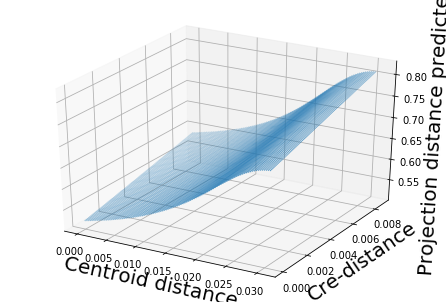

In [47]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)

In [73]:
for m in range(4,5):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_2 = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

4


In [74]:
#gammas = np.asarray([10000,100000,1000000])
gammas = np.asarray([100])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_2,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [   9  772 1070 1072] m [   9  772 1070 1072]
m 0 4 0.004280918 0.005580995995585053
e [] m []
m 1 0 0.004280918 nan
e [] m []
m 2 0 0.004280918 nan
e [] m []
m 3 0 0.004280918 nan
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549514
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.007112192683717562
e [] m []
m 7 0 0.004280918 nan
e [] m []
m 8 0 0.004280918 nan
e [] m []
m 9 0 0.004280918 nan
e [] m []
m 10 0 0.004280918 nan
e [] m []
m 11 0 0.004280918 nan
e [276 575] m [276 575]
m 12 2 0.004280918 nan
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 13 0 0.004280918 nan
e [] m []
m 14 0 0.004280918 nan
e [] m []
m 15 0 0.004280918 nan
e [] m []
m 16 0 0.004280918 nan
e [] m []
m 17 0 0.004280918 nan
e [] m []
m 18 0 0.004280918 nan
e [] m []
m 19 0 0.004280918 nan
e [] m []
m 20 0 0.004280918 nan
e [] m []
m 21 0 0.004280918 nan
e [] m []
m 22 0 0.004280918 nan
e [ 865 1025] m [ 865 1025]
m 23 2 0.004280918 0.0068524631957944705
e [] m []
m 24 0 0.004280918 nan
e [] m []
m 25 0 0.004280918 nan
e [] m []
m 26 0 0.004280918 nan
e [] m []
m 27 0 0.004280918 nan
e [] m []
m 28 0 0.004280918 nan
e [] m []
m 29 0 0.004280918 nan
e [] m []
m 30 0 0.004280918 nan
e [] m []
m 31 0 0.004280918 nan
e [] m []
m 32 0 0.004280918 nan
e [] m []
m 33 0 0.004280918 nan
e [] m []
m 34 0 0.004280918 nan
e [ 47 733 917] m [ 47 733 917]
m 35 3 0.004280918 0.0068678270161480785
e [477 879 892] m [477 879 892]
m 36 3 0.004280918 0.006853318555633702
e [] m []
m 37 0 0.004280918 nan
e [645 711] m [645 711]
m 38 2 0.004280918 nan
e [ 922 1036] m [ 922 1

m 193 2 0.004280918 0.004227922962243035
e [157 527 966] m [157 527 966]
m 194 3 0.004280918 0.004713202686789776
e [] m []
m 195 0 0.004280918 nan
e [] m []
m 196 0 0.004280918 nan
e [488 760] m [488 760]
m 197 2 0.004280918 0.00181067998092308
e [] m []
m 198 0 0.004280918 nan
e [  94 1111] m [  94 1111]
m 199 2 0.004280918 0.0034046068226180576
e [] m []
m 200 0 0.004280918 nan
e [ 70  77  99 621] m [ 70  77  99 621]
m 201 4 0.004280918 0.004970522029364914
e [] m []
m 202 0 0.004280918 nan
e [] m []
m 203 0 0.004280918 nan
e [] m []
m 204 0 0.004280918 nan
e [] m []
m 205 0 0.004280918 nan
e [188 658] m [188 658]
m 206 2 0.004280918 0.0034719419963292384
e [] m []
m 207 0 0.004280918 nan
e [489 736] m [489 736]
m 208 2 0.004280918 0.004045145553527081
e [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918  919  932  945  971 1063] m [  21  145  197  201  207  249  291  351  490  506  582  607  666  669
  687  771  791  802  804  918 

m 323 0 0.004280918 nan
e [] m []
m 324 0 0.004280918 nan
e [196 725] m [196 725]
m 325 2 0.004280918 0.005509440051562989
e [367 455] m [367 455]
m 326 2 0.004280918 0.005631905882799767
e [628 737] m [628 737]
m 327 2 0.004280918 0.004073698661355749
e [265 958] m [265 958]
m 328 2 0.004280918 0.005091799687637347
e [] m []
m 329 0 0.004280918 nan
e [] m []
m 330 0 0.004280918 nan
e [ 721 1045] m [ 721 1045]
m 331 2 0.004280918 0.0034409268214526116
e [] m []
m 332 0 0.004280918 nan
e [] m []
m 333 0 0.004280918 nan
e [] m []
m 334 0 0.004280918 nan
e [] m []
m 335 0 0.004280918 nan
e [] m []
m 336 0 0.004280918 nan
e [142 912] m [142 912]
m 337 2 0.004280918 0.003424454569697642
e [120 681] m [120 681]
m 338 2 0.004280918 0.004819752549207959
e [ 24 491] m [ 24 491]
m 339 2 0.004280918 0.004263835524943217
e [] m []
m 340 0 0.004280918 nan
e [253 653 789 821] m [253 653 789 821]
m 341 4 0.004280918 0.0036397351592040985
e [] m []
m 342 0 0.004280918 nan
e [470 988] m [470 988]
m 343

m 491 0 0.004280918 nan
e [320 793] m [320 793]
m 492 2 0.004280918 0.0031343135040841855
e [  55  191  481  851  907 1059] m [  55  191  481  851  907 1059]
m 493 6 0.004280918 0.003594944534052795
e [  67  198  501  505  870  940 1031 1048] m [  67  198  501  505  870  940 1031 1048]
m 494 8 0.004280918 0.0026844071125947376
e [] m []
m 495 0 0.004280918 nan
e [] m []
m 496 0 0.004280918 nan
e [ 170 1116] m [ 170 1116]
m 497 2 0.004280918 0.0015477052548145346
e [] m []
m 498 0 0.004280918 nan
e [104 337 438 615 724 743 841 900 967] m [104 337 438 615 724 743 841 900 967]
m 499 9 0.004280918 0.0037217219135999013
e [ 25 927] m [ 25 927]
m 500 2 0.004280918 0.0025744897116406107
e [141 494 704] m [141 494 704]
m 501 3 0.004280918 0.0029471237057407365
e [332 403 705] m [332 403 705]
m 502 3 0.004280918 0.003149092062790991
e [   2  129  163  327  442  531  536  590  620  886 1038 1056] m [   2  129  163  327  442  531  536  590  620  886 1038 1056]
m 503 12 0.004280918 0.0033267530890

In [75]:
a= [list(range(1))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0


In [67]:
meanloss_nw_leaf_leaf2_2stage

array([0.17423488])

In [76]:
meanloss_nw_leaf_leaf2_2stage

array([0.17423488])

In [72]:
meanloss_nw_leaf_leaf2_2stage

array([0.17423488])

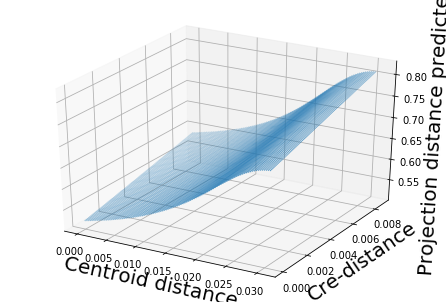

In [77]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)

In [78]:
connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv.coordinates_normed

array([[5.50240469e-05, 1.88611047e-03],
       [7.03739973e-04, 5.43849374e-03],
       [4.49030253e-04, 4.53005103e-03],
       ...,
       [1.33062381e-03, 7.74686435e-03],
       [8.13612252e-03, 4.45594659e-03],
       [0.00000000e+00, 1.10139341e-04]])

<IPython.core.display.Javascript object>


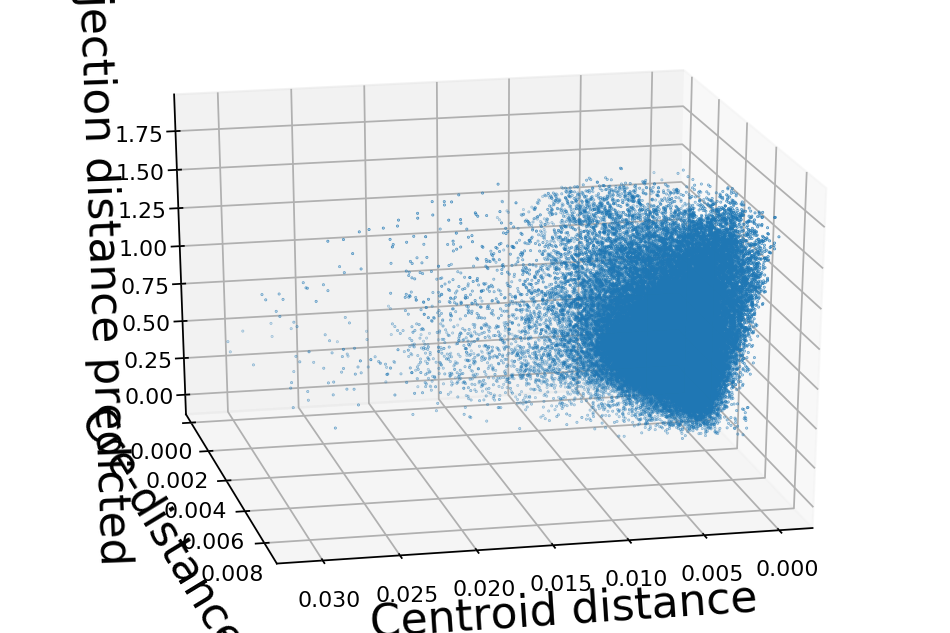

In [89]:
%matplotlib notebook
plot_loss_scatter(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)

In [91]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 1.,
                                                                                                 gamma = 200000)
    
    

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


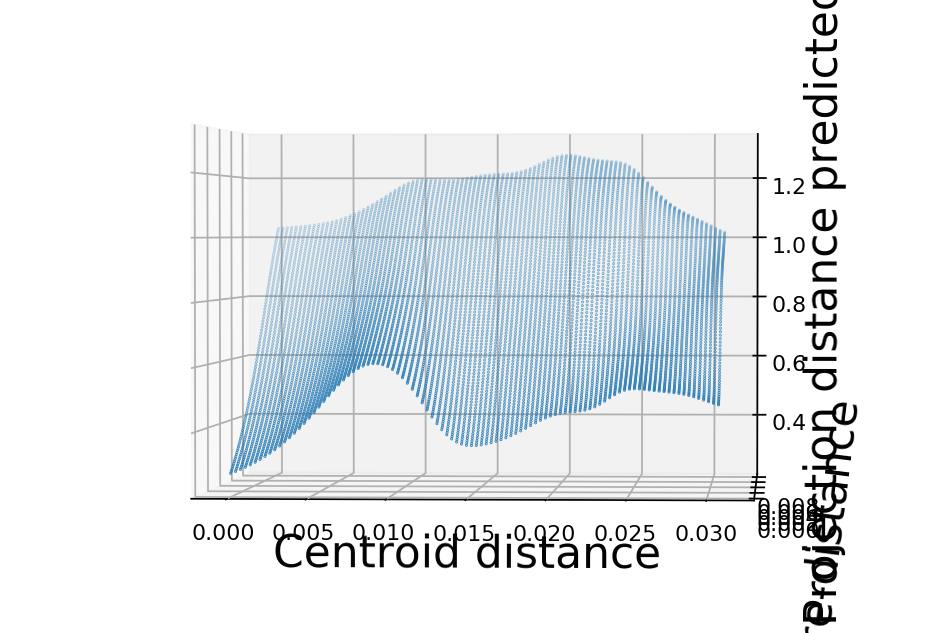

In [92]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)

In [ ]:
.4 *

In [93]:
for m in range(4,5):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_2 = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

4


In [98]:
#gammas = np.asarray([10000,100000,1000000])
gammas = np.asarray([1,10])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_2,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [   9  772 1070 1072] m [   9  772 1070 1072]
e [   9  772 1070 1072] m [   9  772 1070 1072]
m 0 4 0.004280918 0.005613858538796635
e [] m []
e [] m []
m 1 0 0.004280918 nan
e [] m []
e [] m []
m 2 0 0.004280918 nan
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549515
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.007112192683717562
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] m []
m 8 0 0.004280918 nan
e [] m []
e [] m []
m 9 0 0.004280918 nan
e [] m []
e [] m []
m 10 0 0.004280918 nan
e [] m []
e [] m []
m 11 0 0.004280918 nan
e [276 575] m [276 575]
e [276 575] m [276 575]
m 12 2 0.004280918 nan
e [] m []
e [] m []
m 13 0 0.004280918 nan
e [] m []
e [] m []
m 14 0 0.004280918 nan
e [] m []
e [] m []
m 15 0 0.004280918 nan
e [] m []
e [] m []
m 16 0 0.004280918 nan
e [] m []
e [] m []
m 17 0 0.004280918 nan
e [] m []
e [] m []
m 18 0 0.004280918 nan
e [] m []
e [] m []
m 19 0 0.004280918 nan
e [] m []
e [] m []
m 20 0 0.004280918 nan
e [] m []
e [] m []
m 21 0 0.004280918 nan
e [] m []
e [] m []
m 22 0 0.004280918 nan
e [ 865 1025] m [ 865 1025]
e [ 865 1025] m [ 865 1025]
m 23 2 0.004280918 0.00685246319579447
e [] m []
e [] m []
m 24 0 0.004280918 nan
e [] m []
e [] m []
m 25 0 0.004280918 nan
e [] m []
e [] m []
m 26 0 0.004280918 nan
e [] m []
e [] m []
m 27 0 0.004280918 nan
e [] m []
e [] m []
m 28 0 0.0

m 136 0 0.004280918 nan
e [ 151  202  427  926 1022] m [ 151  202  427  926 1022]
e [ 151  202  427  926 1022] m [ 151  202  427  926 1022]
m 137 5 0.004280918 0.004572238132707389
e [516 750] m [516 750]
e [516 750] m [516 750]
m 138 2 0.004280918 nan
e [] m []
e [] m []
m 139 0 0.004280918 nan
e [] m []
e [] m []
m 140 0 0.004280918 nan
e [617 974] m [617 974]
e [617 974] m [617 974]
m 141 2 0.004280918 nan
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
m 142 3 0.004280918 0.0031530261112109074
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
m 143 2 0.004280918 nan
e [] m []
e [] m []
m 144 0 0.004280918 nan
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
m 145 4 0.004280918 0.004257537207541192
e [742 972] m [742 972]
e [742 972] m [742 972]
m 146 2 0.004280918 0.003359079096991181
e [] m []
e [] m []
m 147 0 0.004280918 nan
e [ 553 1103] m [ 553 1103]
e [ 553 1103] m [ 553 1103]
m 148 2 0.004280918

m 235 2 0.004280918 0.0026283634993806235
e [  75  222  231  268  270  306  347  349  372  374  476  602  641  717
  740  780  962 1106 1115] m [  75  222  231  268  270  306  347  349  372  374  476  602  641  717
  740  780  962 1106 1115]
e [  75  222  231  268  270  306  347  349  372  374  476  602  641  717
  740  780  962 1106 1115] m [  75  222  231  268  270  306  347  349  372  374  476  602  641  717
  740  780  962 1106 1115]
m 236 19 0.004280918 0.004631829372931296
e [ 343  550  850  871 1061] m [ 343  550  850  871 1061]
e [ 343  550  850  871 1061] m [ 343  550  850  871 1061]
m 237 5 0.004280918 0.003037408515186698
e [ 173  675 1090] m [ 173  675 1090]
e [ 173  675 1090] m [ 173  675 1090]
m 238 3 0.004280918 0.0031959048760844045
e [  23   87  110  300  324  397  412  449  518 1080 1108] m [  23   87  110  300  324  397  412  449  518 1080 1108]
e [  23   87  110  300  324  397  412  449  518 1080 1108] m [  23   87  110  300  324  397  412  449  518 1080 1108]
m 239

m 327 2 0.004280918 0.004073698661355749
e [265 958] m [265 958]
e [265 958] m [265 958]
m 328 2 0.004280918 0.005091799687637347
e [] m []
e [] m []
m 329 0 0.004280918 nan
e [] m []
e [] m []
m 330 0 0.004280918 nan
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
m 331 2 0.004280918 0.003440926821452612
e [] m []
e [] m []
m 332 0 0.004280918 nan
e [] m []
e [] m []
m 333 0 0.004280918 nan
e [] m []
e [] m []
m 334 0 0.004280918 nan
e [] m []
e [] m []
m 335 0 0.004280918 nan
e [] m []
e [] m []
m 336 0 0.004280918 nan
e [142 912] m [142 912]
e [142 912] m [142 912]
m 337 2 0.004280918 0.003424454569697642
e [120 681] m [120 681]
e [120 681] m [120 681]
m 338 2 0.004280918 0.004819752549207959
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
m 339 2 0.004280918 0.004263835524943217
e [] m []
e [] m []
m 340 0 0.004280918 nan
e [253 653 789 821] m [253 653 789 821]
e [253 653 789 821] m [253 653 789 821]
m 341 4 0.004280918 0.0036697651267447937
e [] m []
e [] m []
m 342 0 0.00

e [ 131  331  360  381  429  566  586 1001] m [ 131  331  360  381  429  566  586 1001]
m 455 8 0.004280918 0.0041631406105718406
e [] m []
e [] m []
m 456 0 0.004280918 nan
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
m 457 2 0.004280918 0.0036558144574737857
e [] m []
e [] m []
m 458 0 0.004280918 nan
e [] m []
e [] m []
m 459 0 0.004280918 nan
e [] m []
e [] m []
m 460 0 0.004280918 nan
e [] m []
e [] m []
m 461 0 0.004280918 nan
e [] m []
e [] m []
m 462 0 0.004280918 nan
e [] m []
e [] m []
m 463 0 0.004280918 nan
e [  5 734] m [  5 734]
e [  5 734] m [  5 734]
m 464 2 0.004280918 0.0028382476077981
e [] m []
e [] m []
m 465 0 0.004280918 nan
e [] m []
e [] m []
m 466 0 0.004280918 nan
e [699 856 982] m [699 856 982]
e [699 856 982] m [699 856 982]
m 467 3 0.004280918 0.003199972050768844
e [153 774 891] m [153 774 891]
e [153 774 891] m [153 774 891]
m 468 3 0.004280918 0.0036543299497620737
e [] m []
e [] m []
m 469 0 0.004280918 nan
e [ 43 609 636 885 950] m [ 43 609

In [95]:
a= [list(range(1))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0


In [96]:
meanloss_nw_leaf_leaf2_2stage

array([0.1752581])

In [97]:
best_gamma_leaf_leaf2

array([[0]])

<IPython.core.display.Javascript object>


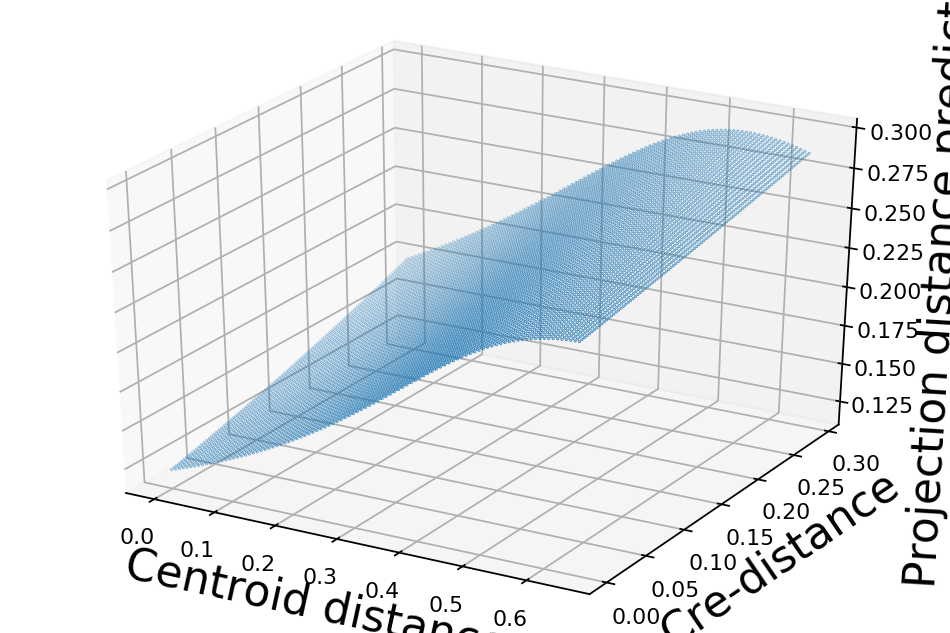

In [100]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[0]].loss_surface_cv)

In [101]:
    #for m in range(4,5):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_2 = get_embedding_cv(surface = connectivity_data.structure_datas[512].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

4


In [106]:
#gammas = np.asarray([10000,100000,1000000])
gammas = np.asarray([.1,1,10])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_2,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [   9  772 1070 1072] m [   9  772 1070 1072]
e [   9  772 1070 1072] m [   9  772 1070 1072]
e [   9  772 1070 1072] m [   9  772 1070 1072]
m 0 4 0.004280918 0.005631588569512702
e [] m []
e [] m []
e [] m []
m 1 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 2 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549514
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.007112192683717563
e [] m []
e [] m []
e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 8 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 9 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 10 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 11 0 0.004280918 nan
e [276 575] m [276 575]
e [276 575] m [276 575]
e [276 575] m [276 575]
m 12 2 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 13 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 14 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 15 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 16 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 17 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 18 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 19 0 0.004280918 nan
e [] m

e [ 385  435  483  977 1033] m [ 385  435  483  977 1033]
m 112 5 0.004280918 0.004679243963297853
e [] m []
e [] m []
e [] m []
m 113 0 0.004280918 nan
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
m 114 3 0.004280918 0.004284238037918455
e [] m []
e [] m []
e [] m []
m 115 0 0.004280918 nan
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
m 116 2 0.004280918 0.003744107671338869
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
m 117 2 0.004280918 0.003714040022034194
e [] m []
e [] m []
e [] m []
m 118 0 0.004280918 nan
e [  86 1117] m [  86 1117]
e [  86 1117] m [  86 1117]
e [  86 1117] m [  86 1117]
m 119 2 0.004280918 0.0034659595971450454
e [ 329  365 1126] m [ 329  365 1126]
e [ 329  365 1126] m [ 329  365 1126]
e [ 329  365 1126] m [ 329  365 1126]
m 120 3 0.004280918 0.004397294333561601
e [] m []
e [] m []
e [] m []
m 121 0 0.004280918 nan
e [587 598] m [587 598]
e [58

e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
e [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125] m [  41   74   93  101  121  148  305  321  346  348  394  398  410  444
  492  512  573  630  632  696  697  765  778  811  829  863  883 1029
 1086 1100 1125]
m 210 31 0.004280918 0.00503955425

e [237 354 755] m [237 354 755]
e [237 354 755] m [237 354 755]
m 250 3 0.004280918 0.006959106021662399
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
e [ 27  58 499 634 720] m [ 27  58 499 634 720]
m 251 5 0.004280918 0.006711582706273403
e [] m []
e [] m []
e [] m []
m 252 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 253 0 0.004280918 nan
e [209 580] m [209 580]
e [209 580] m [209 580]
e [209 580] m [209 580]
m 254 2 0.004280918 0.007344328812051134
e [] m []
e [] m []
e [] m []
m 255 0 0.004280918 nan
e [ 247  964 1104] m [ 247  964 1104]
e [ 247  964 1104] m [ 247  964 1104]
e [ 247  964 1104] m [ 247  964 1104]
m 256 3 0.004280918 0.003465172369204961
e [440 652] m [440 652]
e [440 652] m [440 652]
e [440 652] m [440 652]
m 257 2 0.004280918 0.0059474875029156835
e [] m []
e [] m []
e [] m []
m 258 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 259 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 260 0 0.004280918 nan
e [ 

m 330 0 0.004280918 nan
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
e [ 721 1045] m [ 721 1045]
m 331 2 0.004280918 0.0034409268214526125
e [] m []
e [] m []
e [] m []
m 332 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 333 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 334 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 335 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 336 0 0.004280918 nan
e [142 912] m [142 912]
e [142 912] m [142 912]
e [142 912] m [142 912]
m 337 2 0.004280918 0.0034244545696976423
e [120 681] m [120 681]
e [120 681] m [120 681]
e [120 681] m [120 681]
m 338 2 0.004280918 0.004819752549207959
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
e [ 24 491] m [ 24 491]
m 339 2 0.004280918 0.004263835524943217
e [] m []
e [] m []
e [] m []
m 340 0 0.004280918 nan
e [253 653 789 821] m [253 653 789 821]
e [253 653 789 821] m [253 653 789 821]
e [253 653 789 821] m [253 653 789 821]
m 341 4 0.004280918 0.003698571792016247
e [] m []
e [] m []
e [] 

m 430 2 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 431 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 432 0 0.004280918 nan
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
e [242 420 685] m [242 420 685]
m 433 3 0.004280918 0.003720820314022816
e [136 299] m [136 299]
e [136 299] m [136 299]
e [136 299] m [136 299]
m 434 2 0.004280918 0.0030429915009297604
e [106 808] m [106 808]
e [106 808] m [106 808]
e [106 808] m [106 808]
m 435 2 0.004280918 0.00521701244088063
e [] m []
e [] m []
e [] m []
m 436 0 0.004280918 nan
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
m 437 3 0.004280918 0.005081107198227819
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
m 438 2 0.004280918 0.007580716722615204
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
e [ 19  50 252 683 946] m [ 19  50 252 683 946]
m 439 5 0.004280918 0.0035665915123959916
e [137 525 763 

m 503 12 0.004280918 0.003369607329897172
e [] m []
e [] m []
e [] m []
m 504 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 505 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
m 506 0 0.004280918 nan
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
m 507 8 0.004280918 0.004015550709881828
e [] m []
e [] m []
e [] m []
m 508 0 0.004280918 nan
e [ 184  443  571  594  840  880  908 1011 1069] m [ 184  443  571  594  840  880  908 1011 1069]
e [ 184  443  571  594  840  880  908 1011 1069] m [ 184  443  571  594  840  880  908 1011 1069]
e [ 184  443  571  594  840  880  908 1011 1069] m [ 184  443  571  594  840  880  908 1011 1069]
m 509 9 0.004280918 0.0028790183919953157
e [] m []
e [] m []
e [] m []
m 510 0 0.004280918 nan
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
e [ 259 1107] m [ 259 1107]
m 511 2 0.0

In [107]:
a= [list(range(3))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())[4:5]):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


0


In [108]:
meanloss_nw_leaf_leaf2_2stage

array([0.18532579])

In [109]:
best_gamma_leaf_leaf2

array([[2]])

In [111]:
np.asarray(np.where(~np.isnan(connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv))).transpose().shape

(79293, 2)